## Hoang Khang Pham - 126459239
## Minh Tan To

# Import Libraries

In [100]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


# Prepare dataset

## Import dataset


In [101]:
df = pd.read_csv("CC GENERAL.csv", nrows=5000)

## Handle missing values

In [102]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    160
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [103]:
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
df.drop('CUST_ID', axis=1, inplace=True)

/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/3618717446.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)


## Frame the Problem & Train/Test Split
- The objective of this project is to use unsupervised learning to identify natural
customer segments based on credit card usage patterns.  
There is no target variable; instead, we explore latent structure in spending,
cash advances, payment behavior, and account activity.  
The goal is to support business decisions such as customer segmentation,
credit limit adjustments, and marketing strategies.

- Define your unsupervised objective (e.g., customer segments, usage patterns).

    - Discover **customer segments** based on spending, cash advance, and payment behavior.
    - Help the business design **targeted marketing campaigns**, **risk policies**, and
    **credit limit strategies** for each segmen
- Identify features (no explicit target).
- Create three splits: train_size = {0.10, 0.25, 0.30}.
- Keep the test set unseen until final evaluation

In [104]:
X = df.copy()
train_size = {0.10, 0.25, 0.30}
for size in train_size:
    X_train, X_test = train_test_split(X, test_size=size, random_state=42)
    print(f"Train size: {X_train.shape}, Test size: {X_test.shape} for test_size={size}")

Train size: (4500, 17), Test size: (500, 17) for test_size=0.1
Train size: (3750, 17), Test size: (1250, 17) for test_size=0.25
Train size: (3500, 17), Test size: (1500, 17) for test_size=0.3


# EDA (Exploratory Data Analysis)
- head(), info(), shape, missing counts.
- Histograms & boxplots for distribution.
- Correlation heatmap to spot redundant features.

In [105]:
print(df.head())
print(df.info())
print(df.shape)
print(df.isnull().sum())

       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                

## Histograms & Boxplots

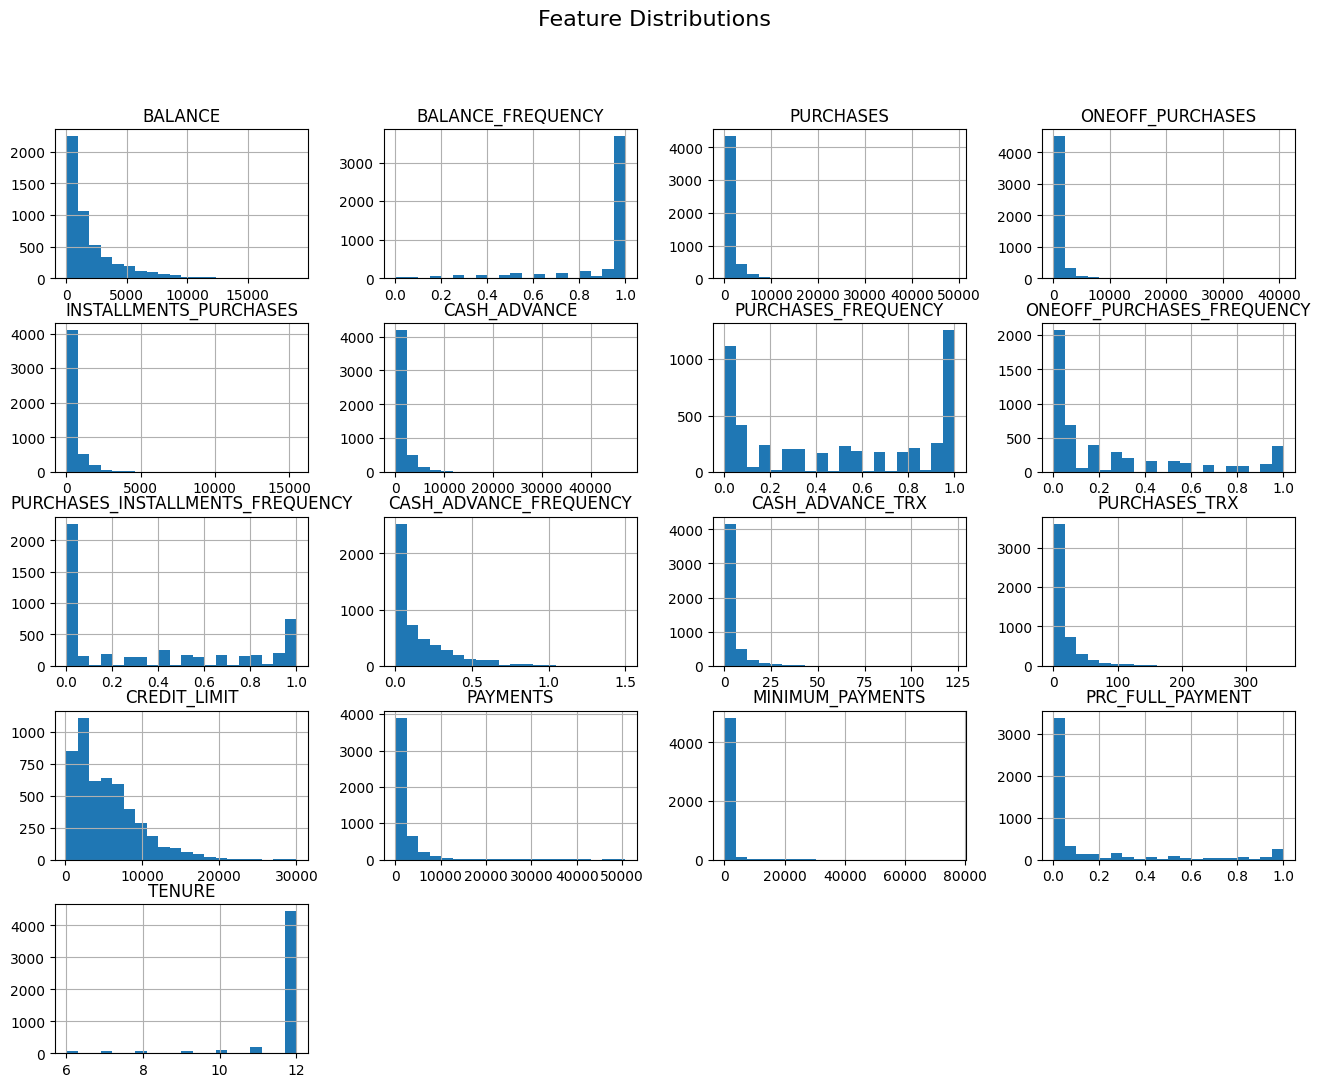

In [106]:

df.hist(figsize=(16, 12), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


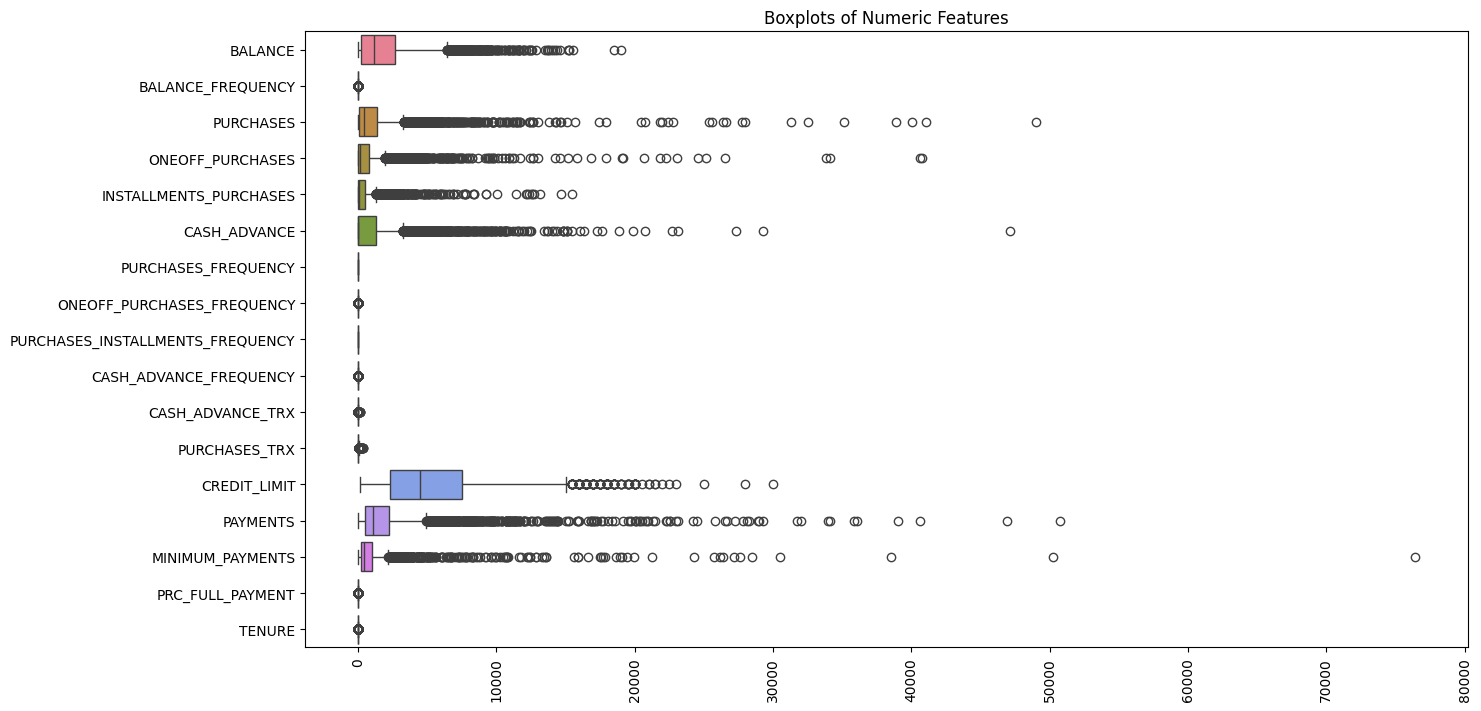

In [107]:

plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient="h")
plt.xticks(rotation=90)
plt.title("Boxplots of Numeric Features")
plt.show()


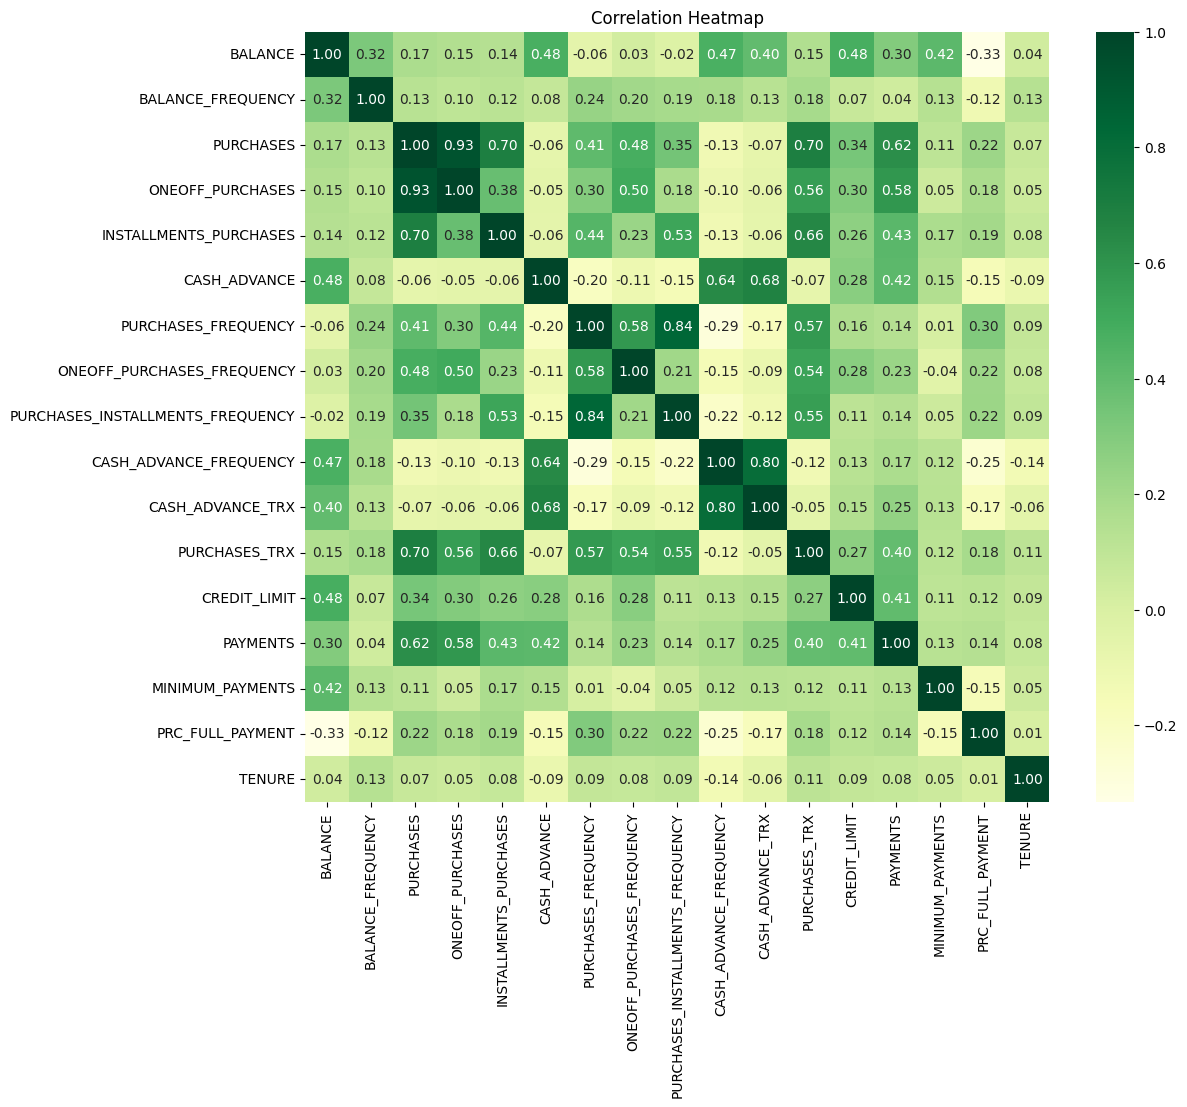

In [108]:
plt.figure(figsize =(12,10))
sns.heatmap(df.corr(), annot = True, cmap ="YlGn", fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Categorical Handling
- Detect categorical columns.
- Apply One-Hot Encoding or Ordinal Encoding (briefly justify choice).

- No categorical features are present after dropping CUST_ID
- so One-Hot/Ordinal encoding is not required. 
- All features are numeric and suitable for scaling + clustering.
    

In [109]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_col)
num_col = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", num_col)


Categorical columns: []
Numerical columns: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


# Custom Feature Engineering
- Add ≥ 1 new feature (e.g., ratio, grouped mean).
- Implement as FunctionTransformer or custom BaseEstimator.

- TOTAL_PURCHASES_VALUE
- AVG_PURCHASE_AMOUNT
- PURCHASE_RATIO
- CASH_TO_PURCHASES
- CASH_ADVANCE_PER_TRX
- BALANCE_LIMIT_RATIO
- PAY_MIN_RATIO
- PAY_BALANCE_RATIO
- PURCHASE_BEHAVIOR_SCORE
- IS_FULL_PAYER

In [110]:
from sklearn.compose import ColumnTransformer
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def add_features(self, X):
        df = X.copy()
        if "TENURE" in df.columns: # TENURE removed because it is constant (all = 12).
            df = df.drop(columns=["TENURE"])
         # 1. Tổng giá trị mua
        df['TOTAL_PURCHASES_VALUE'] = (df['ONEOFF_PURCHASES'] +df['INSTALLMENTS_PURCHASES'])
        # 2. Giá trị trung bình mỗi lần mua
        df['AVG_PURCHASE_AMOUNT'] = (df['TOTAL_PURCHASES_VALUE'] / (df['PURCHASES_TRX'] + 1))
        # 3. Tỷ lệ mua 1 lần / trả góp
        df['PURCHASE_RATIO'] = (df['ONEOFF_PURCHASES'] / (df['INSTALLMENTS_PURCHASES'] + 1))
        # 4. Tỷ lệ rút tiền mặt / tổng mua
        df['CASH_TO_PURCHASES'] = (df['CASH_ADVANCE'] / (df['TOTAL_PURCHASES_VALUE'] + 1))
        # 5. Rút tiền mặt trung bình mỗi giao dịch
        df['CASH_ADVANCE_PER_TRX'] = (df['CASH_ADVANCE'] / (df['CASH_ADVANCE_TRX'] + 1))
        # 6. Tỷ lệ sử dụng hạn mức
        df['BALANCE_LIMIT_RATIO'] = (df['BALANCE'] / (df['CREDIT_LIMIT'] + 1))
        # 7. Payment / Minimum Payment
        df['PAY_MIN_RATIO'] = (df['PAYMENTS'] / (df['MINIMUM_PAYMENTS'] + 1))
        # 8. Payment / Balance
        df['PAY_BALANCE_RATIO'] = (df['PAYMENTS'] / (df['BALANCE'] + 1))
        # 9. Điểm hành vi mua
        df['PURCHASE_BEHAVIOR_SCORE'] = (df['PURCHASES_FREQUENCY'] + df['ONEOFF_PURCHASES_FREQUENCY'] + df['PURCHASES_INSTALLMENTS_FREQUENCY'])
        # 10. Full payment flag
        df['IS_FULL_PAYER'] = (df['PRC_FULL_PAYMENT'] > 0.5).astype(int)
        return df

    def transform(self, X):
        return self.add_features(X)

    



# Pipelines
- Create a ColumnTransformer + Pipeline including:
    - Encoder (for categoricals)
    - Scaler (for numerics)
    - Placeholder for model
Use fit() on train only and transform() on test.

In [111]:
temp = AddFeatures().fit_transform(df)
full_cols = temp.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocess = Pipeline([
    ("custom", AddFeatures()),
    ("preprocessor", ColumnTransformer([
        ("nums", num_pipeline, full_cols)
    ], remainder='drop'))
])

processed_data = preprocess.fit_transform(X)
processed_data.shape

(5000, 26)

## Boxplot AFTER scaling

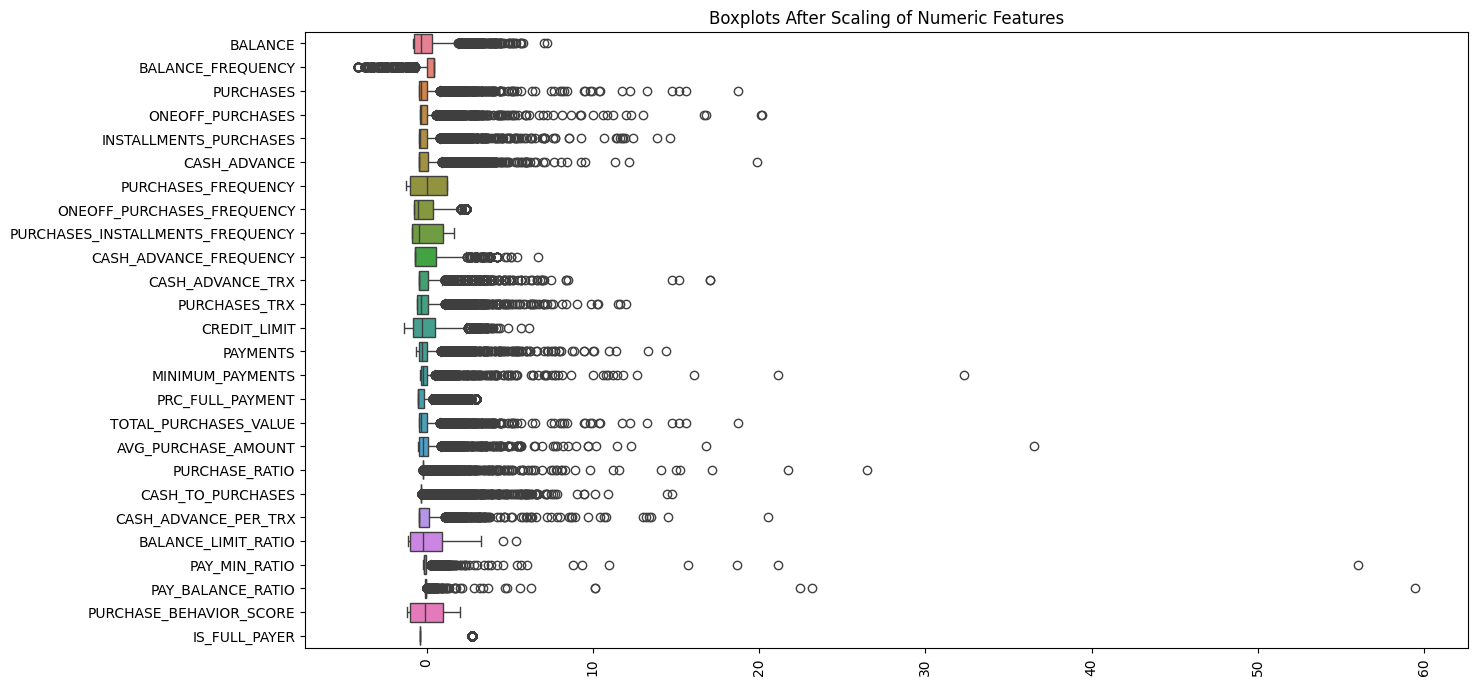

In [112]:
scaled_df = pd.DataFrame(processed_data, columns=full_cols)
plt.figure(figsize=(15, 8))
sns.boxplot(data=scaled_df, orient="h")
plt.xticks(rotation=90)
plt.title("Boxplots After Scaling of Numeric Features")
plt.show()
# Scaling is required because K-Means, Agglomerative, and GMM are distance-based 
# clustering methods. Without scaling, features with large magnitudes (e.g. BALANCE, PAYMENTS)
# dominate smaller features (frequencies), causing biased clusters.



# Model Training & Evaluation

In [113]:
def compute_cluster_metrics(X_train, train_labels, X_test, test_labels):
    return {
        "train_sil": silhouette_score(X_train, train_labels),
        "train_dbi": davies_bouldin_score(X_train, train_labels),
        "train_ch": calinski_harabasz_score(X_train, train_labels),
        
        "test_sil": silhouette_score(X_test, test_labels),
        "test_dbi": davies_bouldin_score(X_test, test_labels),
        "test_ch": calinski_harabasz_score(X_test, test_labels),
    }

# k-mean

In [114]:
test_sizes = [0.90, 0.75, 0.70]
n_clusters_list = [3, 5, 7, 9]
n_init_list = [10, 20, 50]
max_iter_list = [100, 300, 600]

k_mean_results = []
for test_size in test_sizes:
    X_train, X_test = train_test_split(processed_data, test_size=test_size, random_state=42)
    for k in n_clusters_list:
        for n_init in n_init_list:
            for max_iter in max_iter_list:

                kmeans = KMeans(n_clusters=k,n_init=n_init,max_iter=max_iter,random_state=42)
                kmeans.fit(X_train)

                train_labels = kmeans.fit_predict(X_train)
                test_labels = kmeans.predict(X_test)
                full_labels  = kmeans.predict(processed_data)

                metrics = compute_cluster_metrics(X_train, train_labels, X_test, test_labels)

                k_mean_results.append({
                    "model": "KMeans",
                    "labels_full_data": kmeans.fit_predict(processed_data),# add 
                    "train_size": 1-test_size,
                    "n_clusters": k,
                    "params": f"n_init={n_init}, max_iter={max_iter}",
                    "train_labels": train_labels,
                    "test_labels": test_labels,
                    "labels_full_data": full_labels,
                    **metrics
                })

# visual test

/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/2409185720.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=3,cmap=plt.cm.get_cmap('tab10', k))


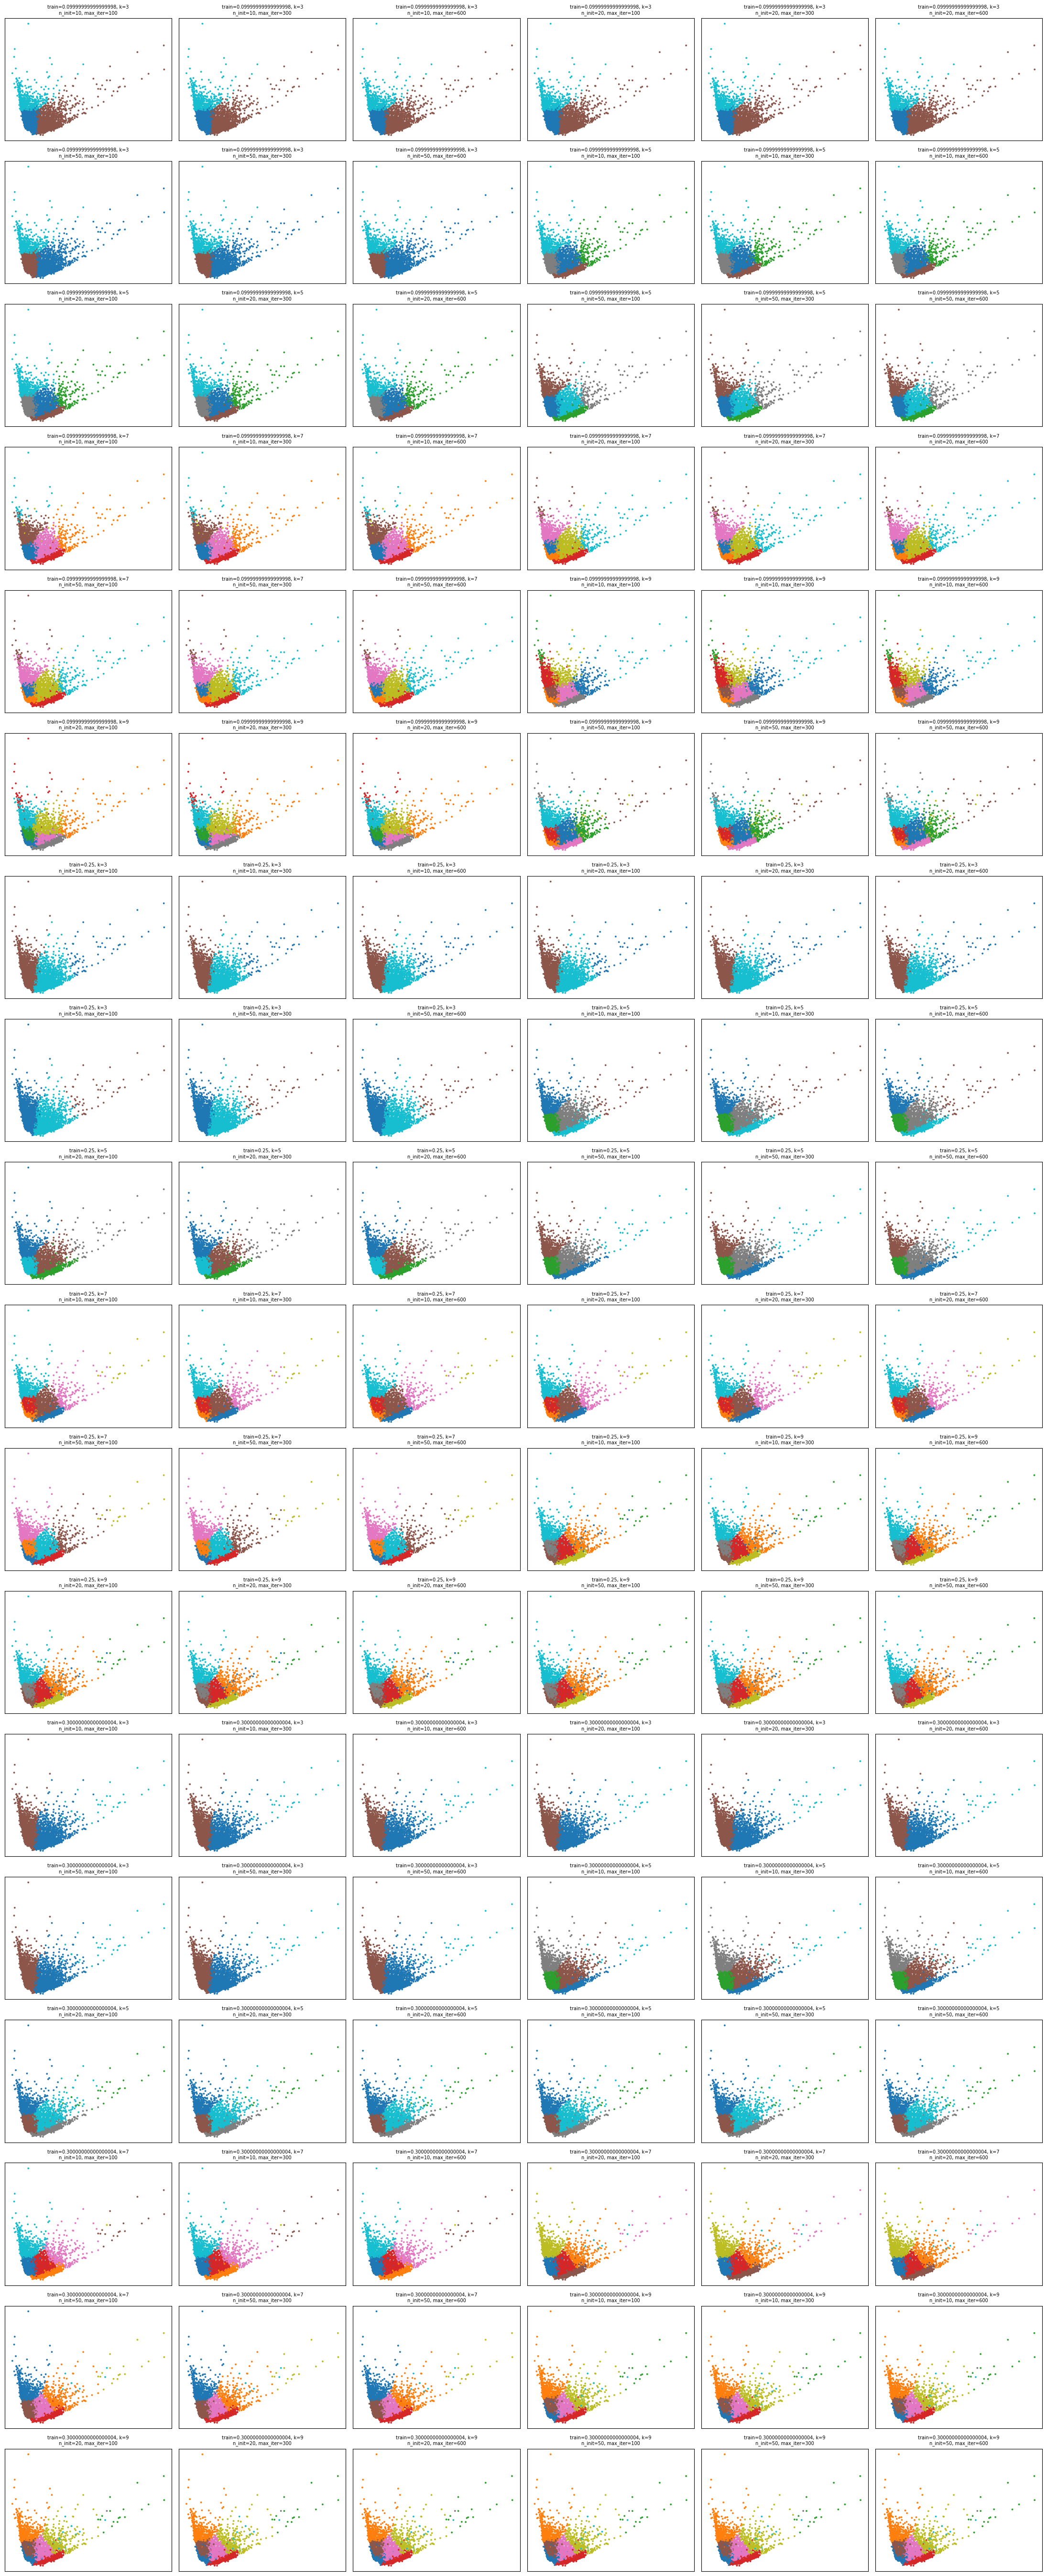

In [115]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math

# Fit PCA one time only
pca = PCA(n_components=2)
X_2d = pca.fit_transform(processed_data)

n_models = len(k_mean_results)
n_cols = 6
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, n_rows * 3))
axes = axes.flatten()

for idx, result in enumerate(k_mean_results):

    labels = result["labels_full_data"] 
    k = result["n_clusters"]
    train_size = result["train_size"]
    params = result["params"]

    ax = axes[idx]

    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=3,cmap=plt.cm.get_cmap('tab10', k))
    ax.set_title(f"train={train_size}, k={k}\n{params}", fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# agglomerative

In [116]:
agglomerative_results = []
for test_size in test_sizes:
    X_train , X_test = train_test_split(processed_data, test_size=test_size, random_state=42)
    for n in n_clusters_list:
        agg_train = AgglomerativeClustering(n_clusters=n)
        train_labels = agg_train.fit_predict(X_train)
        agg_test = AgglomerativeClustering(n_clusters=n)
        test_labels = agg_test.fit_predict(X_test)
        agg_full = AgglomerativeClustering(n_clusters=n)
        full_labels = agg_full.fit_predict(processed_data)
        metrics = compute_cluster_metrics(X_train, train_labels, X_test, test_labels)

        agglomerative_results.append({
            "model": "Agglomerative",
            "train_size": 1 - test_size,
            "n_clusters": n,
            "params": "None",
            "train_labels": train_labels,
            "test_labels": test_labels,
            "labels_full_data": full_labels,# add
            **metrics
            })

/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/442902902.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)


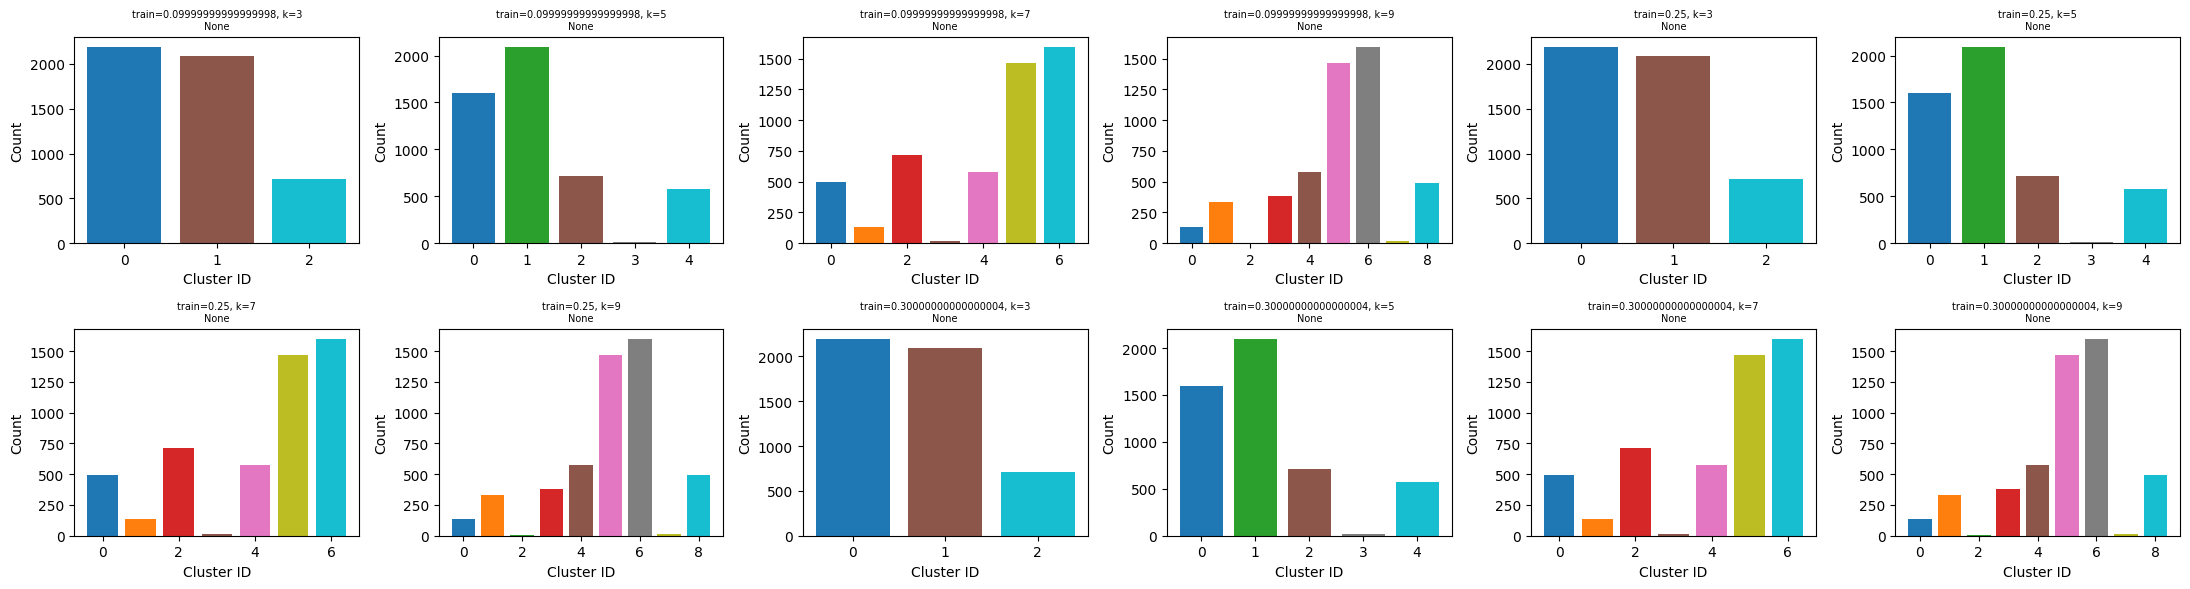

In [117]:
import numpy as np
n_models = len(agglomerative_results)
n_cols = 6
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, n_rows * 3))
axes = axes.flatten()

for idx, result in enumerate(agglomerative_results):

    labels = result["labels_full_data"]
    k = result["n_clusters"]
    train_size = result["train_size"]
    params = result["params"]

    counts = np.bincount(labels)

    ax = axes[idx]
    cmap = plt.cm.get_cmap("tab10", k)
    ax.bar(np.arange(k), counts, color=cmap(np.arange(k)))
    ax.set_title(f"train={train_size}, k={k}\n{params}", fontsize=7)
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Count")

# Turn off extra subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# GMM

In [118]:
gmm_results = []

for test_size in test_sizes:

    X_train, X_test = train_test_split(processed_data, test_size=test_size, random_state=42)

    for k in n_clusters_list:
        for max_iter in max_iter_list:
            gmm = GaussianMixture(n_components=k, max_iter=max_iter, random_state=42)
            gmm.fit(X_train)
            train_labels = gmm.predict(X_train)
            test_labels = gmm.predict(X_test)
            membership = gmm.predict_proba(processed_data) 
            labels_full = gmm.predict(processed_data)
            metrics = compute_cluster_metrics(X_train, train_labels, X_test, test_labels)
            gmm_results.append({
                "model": "GMM",
                "train_size": 1 - test_size,
                "n_clusters": k,
                "params": f"max_iter={max_iter}",
                "labels_full_data": labels_full,
                "membership": membership,
                **metrics
            })


/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/3928679301.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)
/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/3928679301.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", k)
/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/3928679301.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = pl

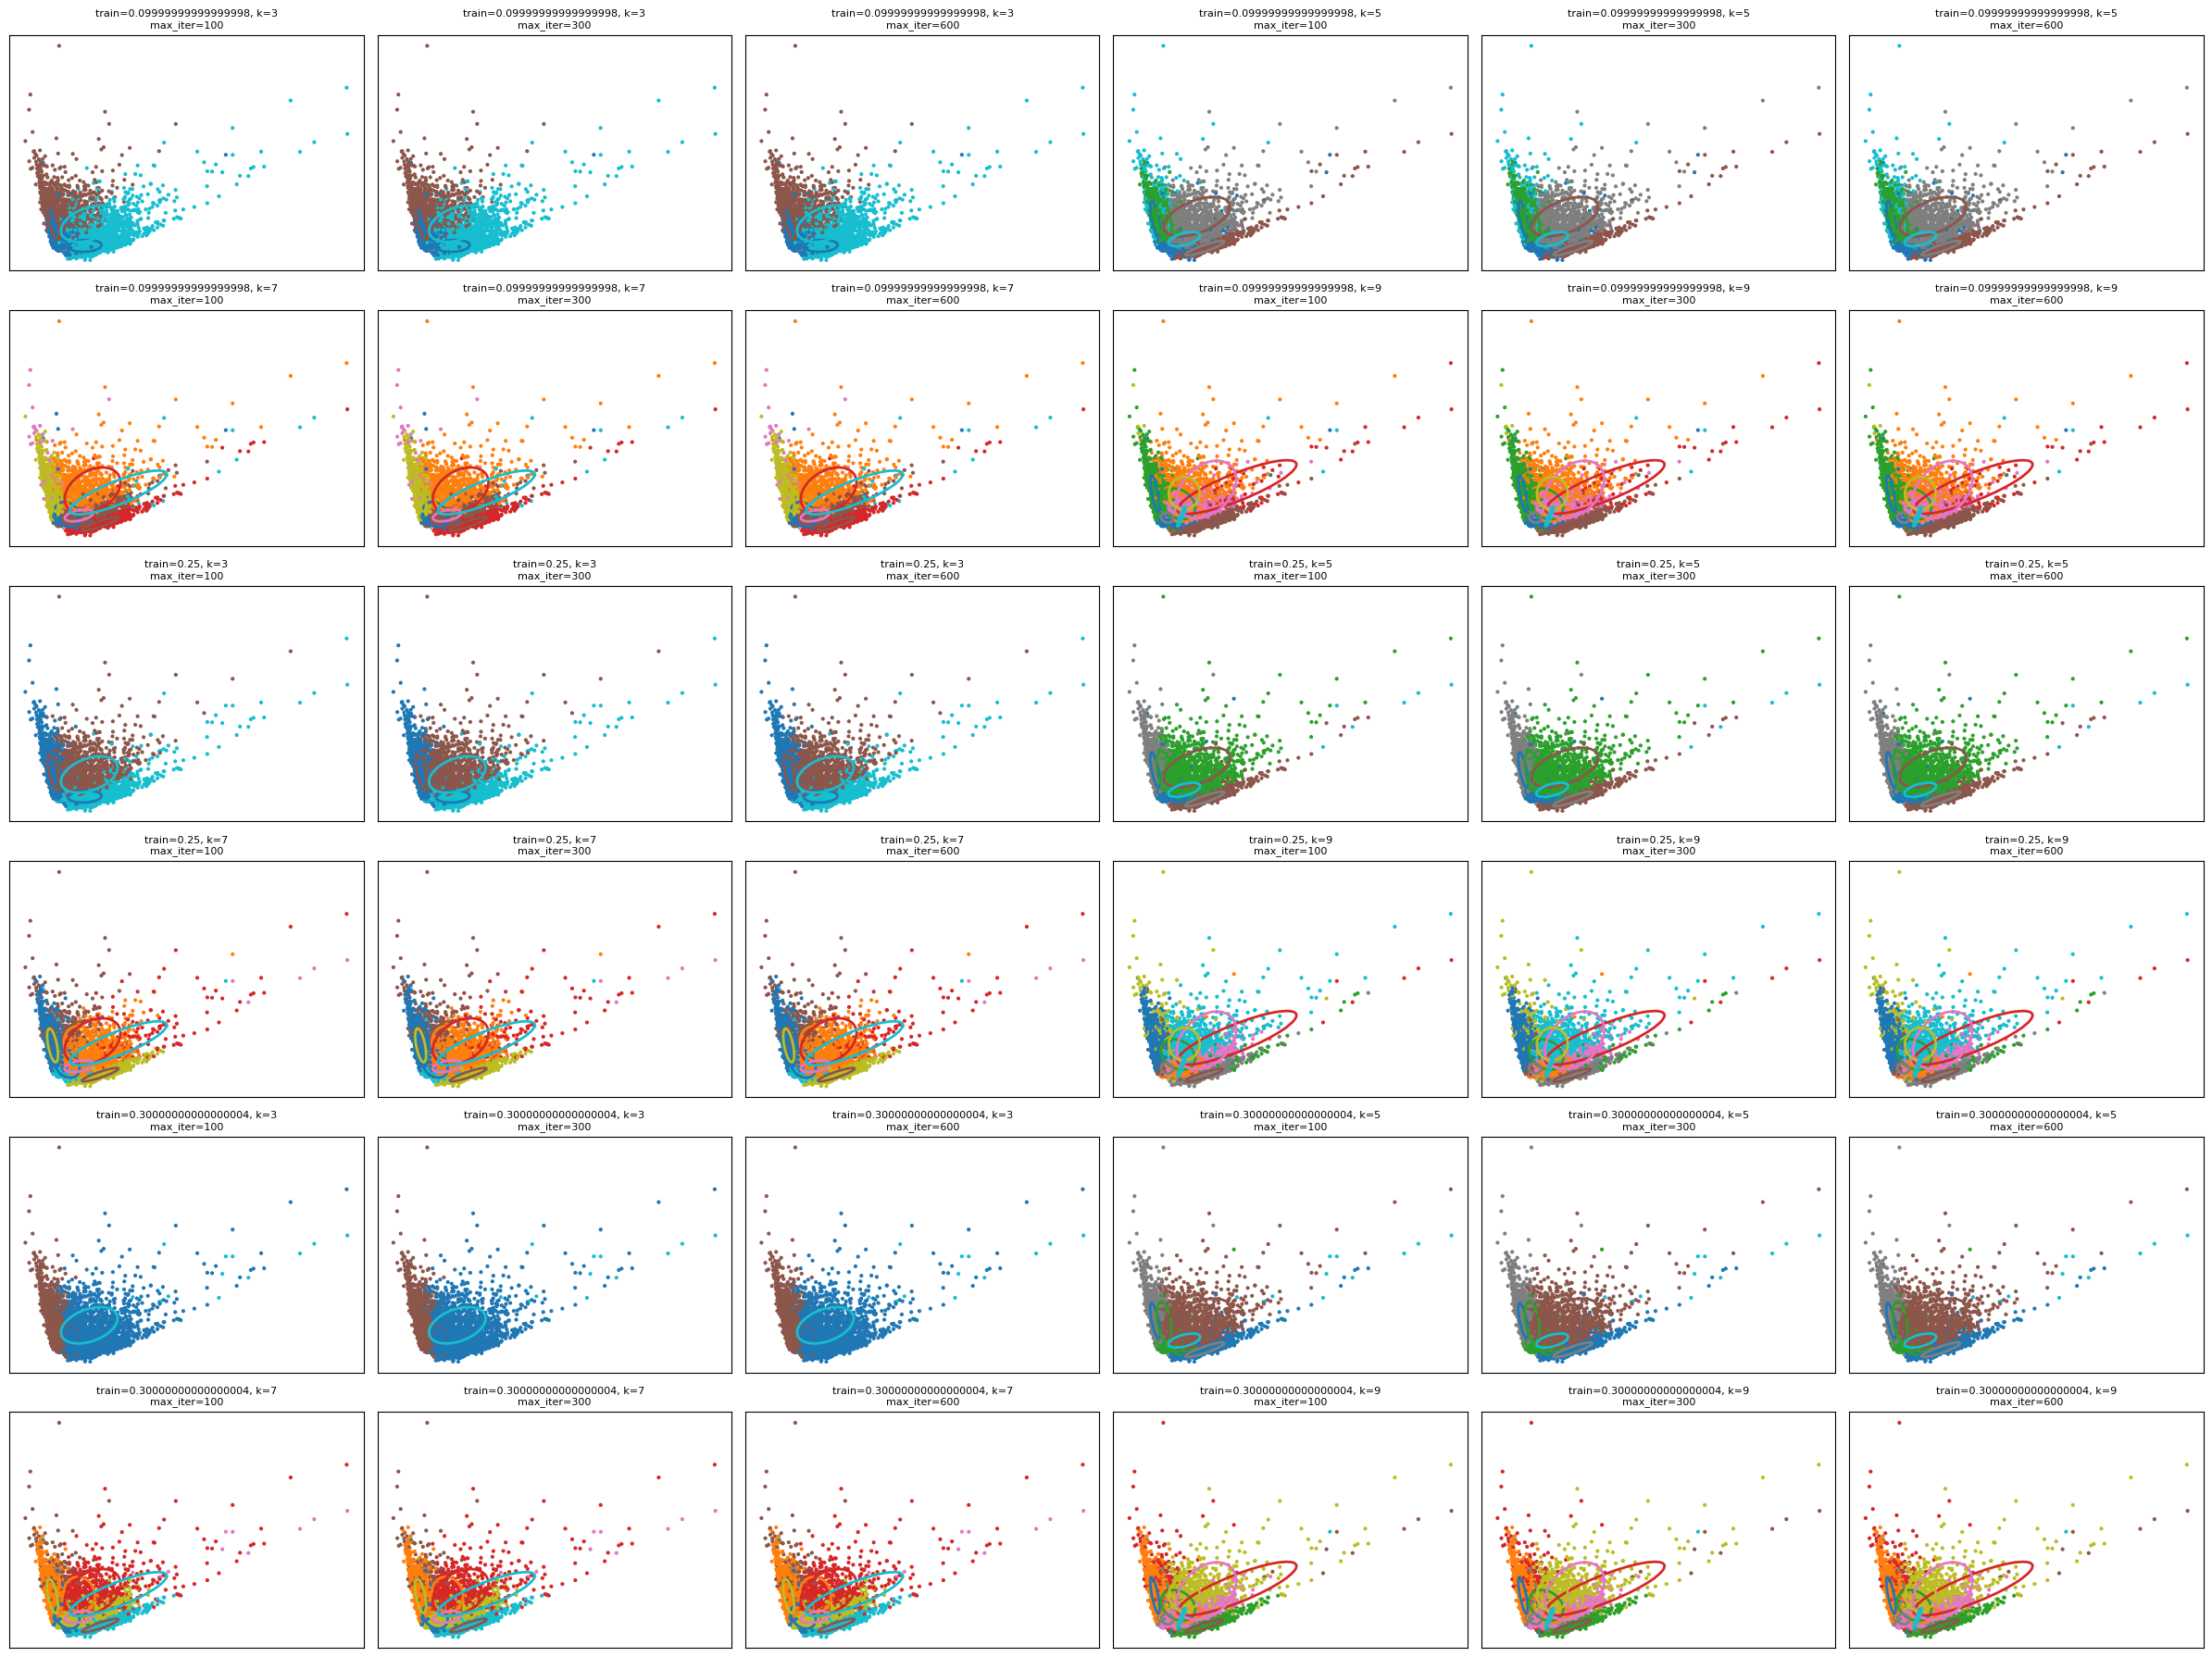

In [119]:
from matplotlib.patches import Ellipse
pca = PCA(n_components=2)
X_2d = pca.fit_transform(processed_data)

def draw_gmm_ellipse(mean_2d, cov_2d, ax, color):
    vals, vecs = np.linalg.eigh(cov_2d)
    width, height = 2 * np.sqrt(vals)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    ellipse = Ellipse(xy=mean_2d, width=width,height=height, angle=angle, edgecolor=color, fill=False,linewidth=2)
    ax.add_patch(ellipse)

n_models = len(gmm_results)
n_cols = 6
n_rows = math.ceil(n_models / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, n_rows * 3))
axes = axes.flatten()
for idx, result in enumerate(gmm_results):

    labels = result["labels_full_data"]
    k = result["n_clusters"]
    params = result["params"]
    train_size = result["train_size"]
    
    
    gmm = GaussianMixture(n_components=k, max_iter=max_iter, random_state=42)
    gmm.fit(processed_data)

    ax = axes[idx]
    cmap = plt.cm.get_cmap("tab10", k)
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=4, cmap=cmap)

    means_2d = pca.transform(gmm.means_)

    for i in range(k):
        # Project covariance to 2D space
        cov_3d = gmm.covariances_[i]           # shape = (27, 27)
        cov_2d = pca.components_ @ cov_3d @ pca.components_.T

        draw_gmm_ellipse(means_2d[i],cov_2d, ax, cmap(i))

    ax.set_title(f"train={train_size}, k={k}\n{params}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide extra axes
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


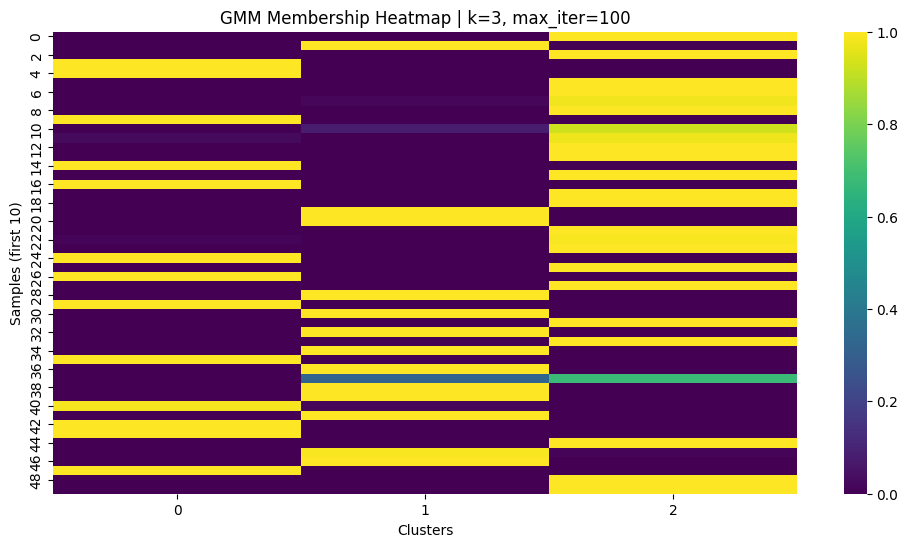

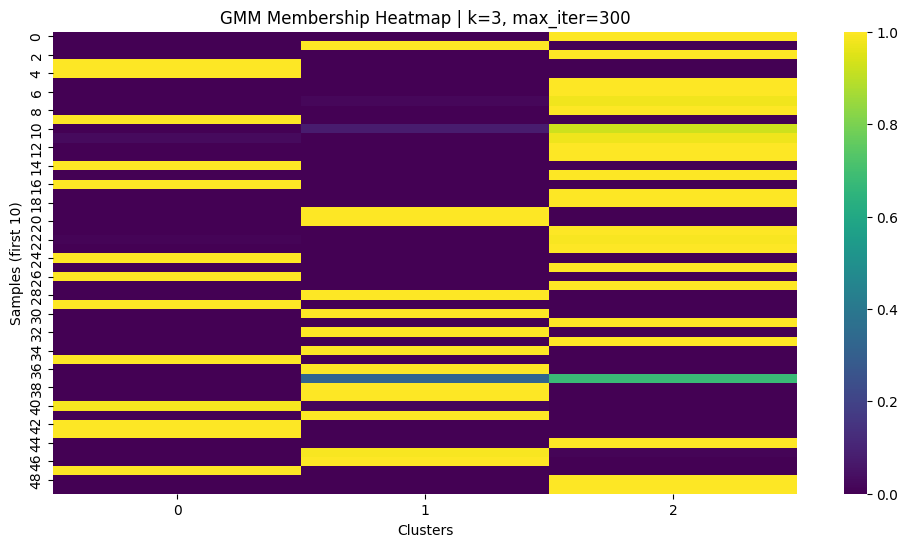

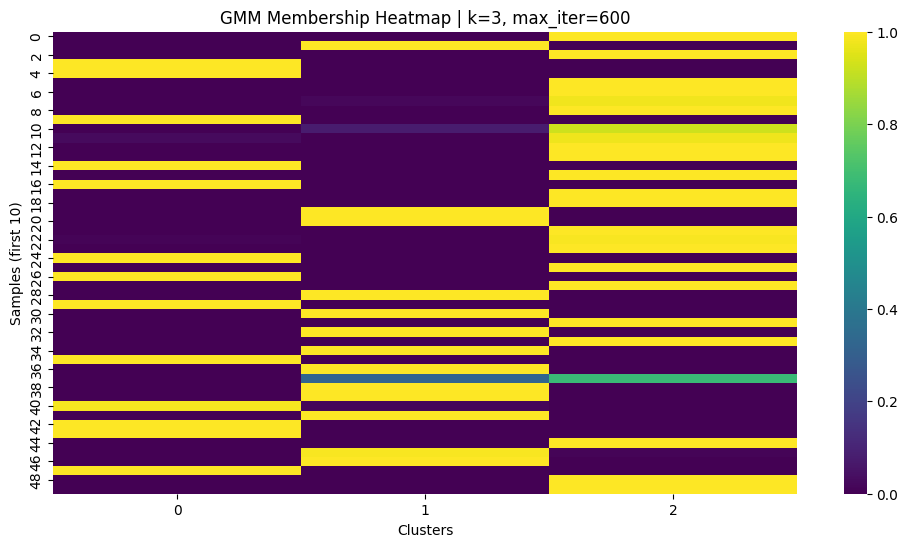

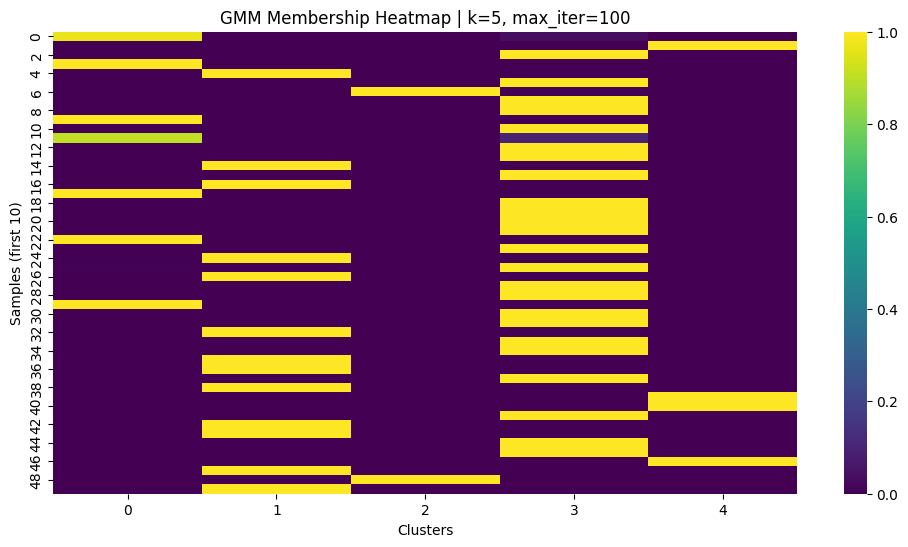

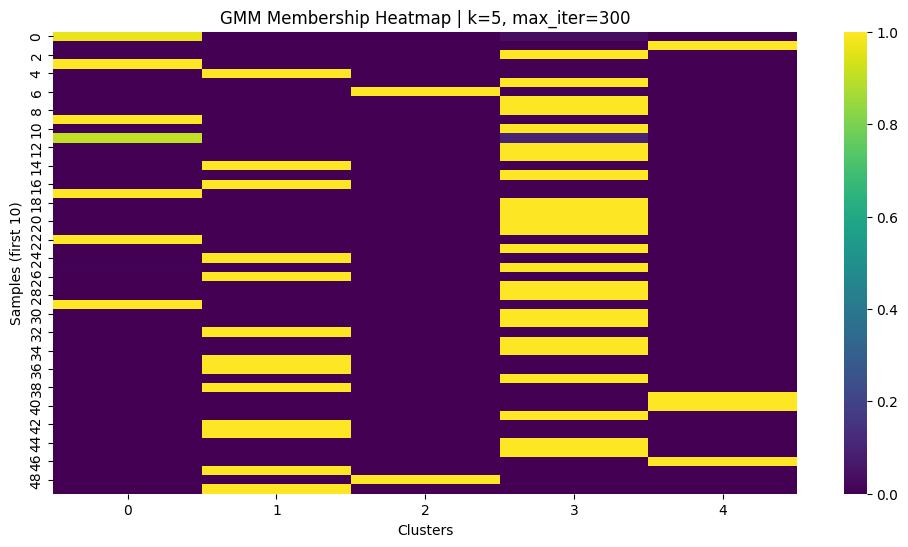

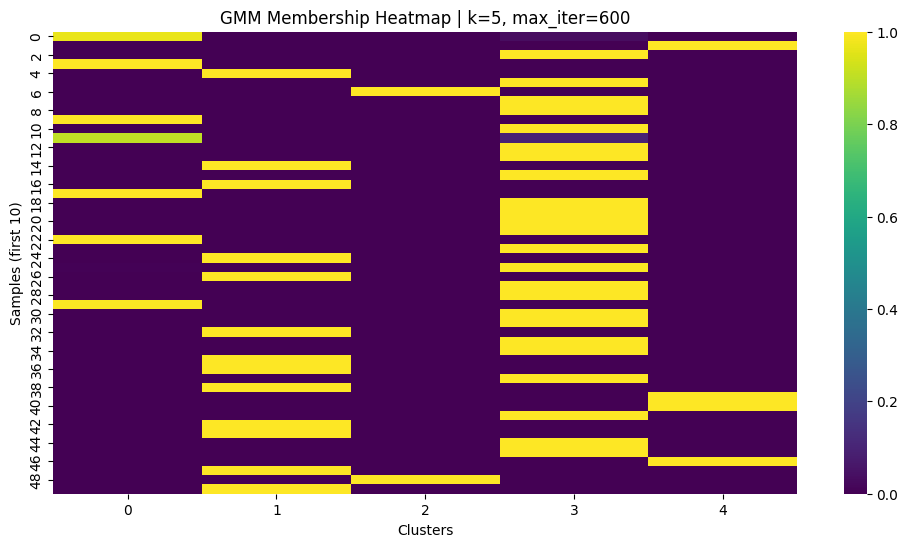

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx, result in enumerate(gmm_results[:6]):  
    probs = result["membership"]
    k = result["n_clusters"]

    plt.figure(figsize=(12, 6))
    sns.heatmap(probs[:50], cmap="viridis")  
    plt.title(f"GMM Membership Heatmap | k={k}, {result['params']}")
    plt.xlabel("Clusters")
    plt.ylabel("Samples (first 10)")
    plt.show()


# Export to csv

In [122]:
all_results = (k_mean_results + agglomerative_results + gmm_results)

df_results = pd.DataFrame(all_results)
df_results.to_csv("clustering_results.csv", index=False)
df_results.head()

model                                   labels_full_data  train_size  \
0  KMeans  [0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...         0.1   
1  KMeans  [0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...         0.1   
2  KMeans  [0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...         0.1   
3  KMeans  [0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...         0.1   
4  KMeans  [0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, ...         0.1   

   n_clusters                   params  \
0           3  n_init=10, max_iter=100   
1           3  n_init=10, max_iter=300   
2           3  n_init=10, max_iter=600   
3           3  n_init=20, max_iter=100   
4           3  n_init=20, max_iter=300   

                                        train_labels  \
0  [0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...   
1  [0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...   
2  [0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...   
3  [0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...   
4  [0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...   

                                         test_labels  train_sil  train_dbi  \
0  [1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, ...   0.207164   1.673436   
1  [1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, ...   0.207164   1.673436   
2  [1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, ...   0.207164   1.673436   
3  [1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, ...   0.207164   1.673436   
4  [1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, ...   0.207164   1.673436   

    train_ch  test_sil  test_dbi    test_ch membership  
0  92.677164  0.199248  1.720239  653.50334        NaN  
1  92.677164  0.199248  1.720239  653.50334        NaN  
2  92.677164  0.199248  1.720239  653.50334        NaN  
3  92.677164  0.199248  1.720239  653.50334        NaN  
4  92.677164  0.199248  1.720239  653.50334        NaN

In [123]:

df_results.to_excel("Group9_Unsupervised_Project_Metrics.xlsx", index=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

metrics = df_results[['train_sil','test_sil','train_dbi','test_dbi','train_ch','test_ch']]
scaler = MinMaxScaler()
normalized = scaler.fit_transform(metrics)
df_results[['sil_train_n','sil_test_n','dbi_train_n','dbi_test_n','ch_train_n','ch_test_n']] = normalized

df_results["score"] = (
    df_results["sil_train_n"] * 0.3 +
    df_results["sil_test_n"] * 0.4 -
    df_results["dbi_train_n"] * 0.1 -
    df_results["dbi_test_n"] * 0.1 +
    df_results["ch_train_n"] * 0.05 +
    df_results["ch_test_n"] * 0.05
)
df_results[[
    "model","train_size","n_clusters","params",
    "train_sil","test_sil","train_dbi","test_dbi","train_ch","test_ch","score"
]].head()

model  train_size  n_clusters                   params  train_sil  \
0  KMeans         0.1           3  n_init=10, max_iter=100   0.207164   
1  KMeans         0.1           3  n_init=10, max_iter=300   0.207164   
2  KMeans         0.1           3  n_init=10, max_iter=600   0.207164   
3  KMeans         0.1           3  n_init=20, max_iter=100   0.207164   
4  KMeans         0.1           3  n_init=20, max_iter=300   0.207164   

   test_sil  train_dbi  test_dbi   train_ch    test_ch    score  
0  0.199248   1.673436  1.720239  92.677164  653.50334  0.60928  
1  0.199248   1.673436  1.720239  92.677164  653.50334  0.60928  
2  0.199248   1.673436  1.720239  92.677164  653.50334  0.60928  
3  0.199248   1.673436  1.720239  92.677164  653.50334  0.60928  
4  0.199248   1.673436  1.720239  92.677164  653.50334  0.60928

In [132]:
best_row = df_results.loc[df_results["score"].idxmax()]
print("Best Model:\n", best_row[[
    "model","train_size","n_clusters","params",
    "train_sil","test_sil","train_dbi","test_dbi","train_ch","test_ch","score"
]])

Best Model:
 model                          KMeans
train_size                        0.3
n_clusters                          5
params        n_init=10, max_iter=100
train_sil                    0.215296
test_sil                     0.211695
train_dbi                    1.465653
test_dbi                      1.44529
train_ch                   249.166612
test_ch                    469.774103
score                        0.719587
Name: 81, dtype: object


In [133]:
params = best_row['params']
n_init = int(params.split(',')[0].split('=')[1])
max_iter = int(params.split(',')[1].split('=')[1])

best_kmeans = KMeans(
    n_clusters=best_row['n_clusters'],
    n_init=n_init,
    max_iter=max_iter,
    random_state=42
)

best_kmeans.fit(processed_data)
best_labels = best_kmeans.predict(processed_data)



In [134]:
df_with_cluster = df.copy()
df_with_cluster['cluster'] = best_labels
cluster_profile = df_with_cluster.groupby('cluster').mean().round(2)
cluster_profile


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
cluster                                                            
0        5201.29               0.96     440.33            284.37   
1        4984.86               0.98   16338.44          11148.98   
2        1306.43               0.84     302.00            234.98   
3        1943.30               0.96    1840.93           1038.73   
4         176.14               0.85    1841.98           1109.48   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
cluster                                                              
0                        155.96       5314.85                 0.23   
1                       5189.46        878.60                 0.92   
2                         67.06        587.72                 0.18   
3                        802.25        465.06                 0.90   
4                        732.66         81.16                 0.79   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
cluster                                                                 
0                              0.12                              0.14   
1                              0.75                              0.78   
2                              0.09                              0.08   
3                              0.41                              0.71   
4                              0.40                              0.56   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
cluster                                                            
0                          0.48             14.31           6.11   
1                          0.08              2.27         129.38   
2                          0.12              2.14           3.18   
3                          0.08              1.64          31.32   
4                          0.01              0.25          25.38   

         CREDIT_LIMIT  PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
cluster                                                                      
0             8585.91   4153.34           1896.03              0.03   11.48  
1            12752.11  15969.32           3637.15              0.38   11.96  
2             3907.32   1050.57            694.27              0.04   11.63  
3             5637.84   2014.07           1056.51              0.07   11.81  
4             6490.43   2068.14            177.98              0.86   11.71

In [135]:
best_test_size = 1 - best_row["train_size"]
X_train_final, X_test_final = train_test_split(processed_data, test_size=best_test_size, random_state=42)

best_kmeans.fit(X_train_final)

train_labels_final = best_kmeans.predict(X_train_final)
test_labels_final = best_kmeans.predict(X_test_final)

print("Final Train/Test Metrics:")
print(compute_cluster_metrics(X_train_final, train_labels_final, X_test_final, test_labels_final))


Final Train/Test Metrics:
{'train_sil': 0.21529559729556835, 'train_dbi': 1.4656525845171307, 'train_ch': 249.16661248034464, 'test_sil': 0.21169462545860315, 'test_dbi': 1.445289919122589, 'test_ch': 469.7741034287207}


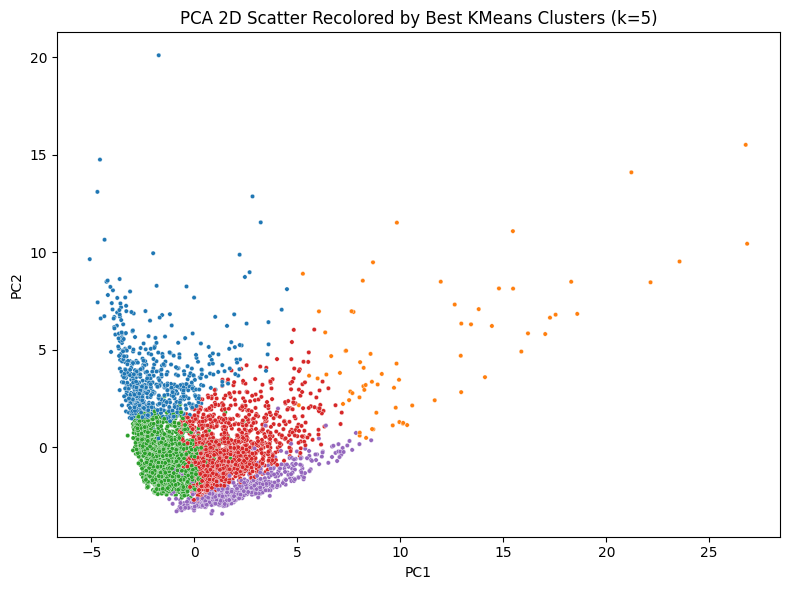

In [136]:
# PCA for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(processed_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=best_labels,
    palette="tab10",
    s=10,
    legend=False
)
plt.title("PCA 2D Scatter Recolored by Best KMeans Clusters (k=5)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

/var/folders/7x/1c_g2v5s46gd3rpq1b_zrd1r0000gn/T/ipykernel_48082/405676943.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


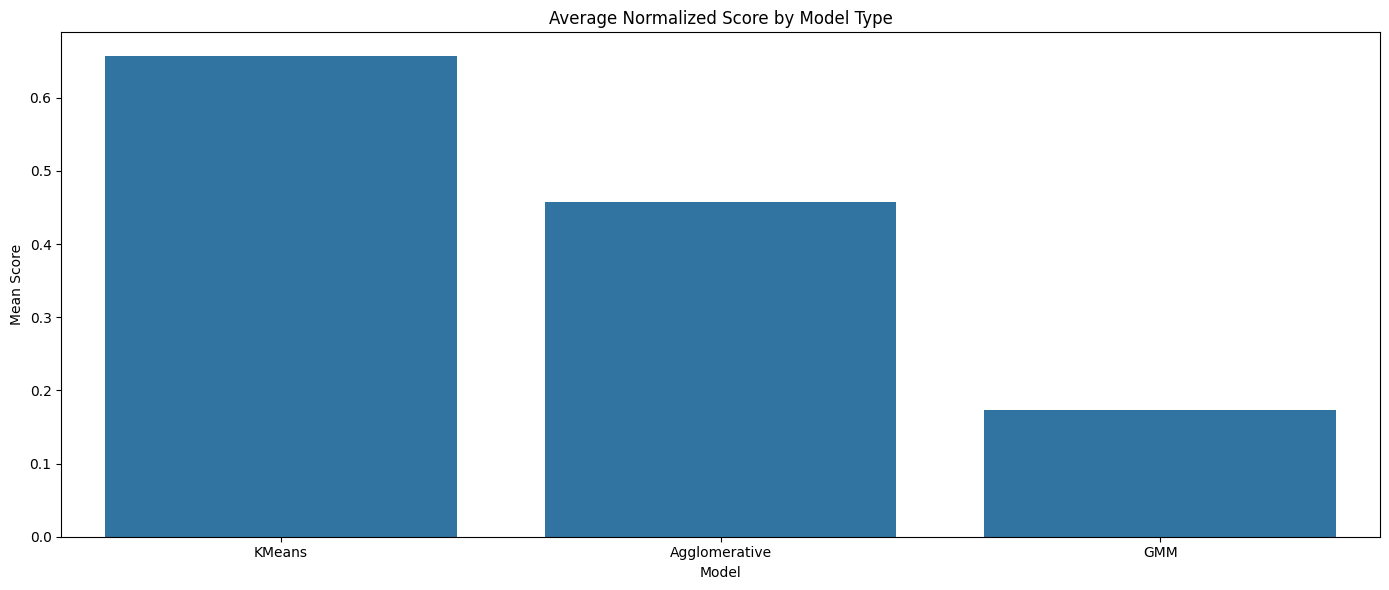

In [137]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_results,
    x="model",
    y="score",
    ci=None
)
plt.title("Average Normalized Score by Model Type")
plt.ylabel("Mean Score")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [131]:
import joblib
joblib.dump(best_kmeans, "best_model.pkl")

['best_model.pkl']